In [144]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from scipy.ndimage import gaussian_filter1d


In [145]:
dataset_path = os.path.join(os.getcwd(), 'dataset')
print(dataset_path)
test_dataset_path = os.path.join(dataset_path, 'test')
train_dataset_path = os.path.join(dataset_path, 'train')

processed_path = os.path.join(os.getcwd(), 'processed')
processed_train_path = os.path.join(processed_path, 'train')
processed_test_path = os.path.join(processed_path, 'test')

/Users/james/Documents/NUS/Y3S1/CS4243/4243miniproj/dataset


In [146]:
def vertical_projection(thresh): 
    projection = np.sum(thresh, axis=0) 
    smoothed_projection = gaussian_filter1d(projection, sigma=1) 
    return smoothed_projection 
 
def drop_fall(thresh, start, end): 
    h, _ = thresh.shape 
    drop_positions = [] 
     
    # Simulate drops along each column within the segment 
    for x in range(start, end): 
        drop_y = 0 
        for y in range(h): 
            if thresh[y, x] > 0:  # Pixel intensity detected 
                drop_y = y 
        drop_positions.append(drop_y) 
     
    # Find potential splitting points where drop_y values show a significant shift 
    drop_boundaries = [] 
    for i in range(1, len(drop_positions)): 
        if abs(drop_positions[i] - drop_positions[i - 1]) > h * 0.1:  # Threshold for split 
            drop_boundaries.append(start + i) 
     
    return drop_boundaries 
 
def segment_by_projection_with_drop_fall(thresh, projection, min_width=5, max_width=100, min_segments=4): 
    h, w = thresh.shape 
    segments = [] 
    in_char = False 
    start = 0 
 
    for i in range(w): 
        if projection[i] > 0 and not in_char: 
            in_char = True 
            start = i 
        elif projection[i] == 0 and in_char: 
            in_char = False 
            end = i 
            segment_width = end - start 
            if segment_width <= max_width: 
                segments.append((start, end)) 
            else: 
                # Apply drop fall algorithm for connected characters 
                drop_boundaries = drop_fall(thresh, start, end) 
                prev_boundary = start 
                for boundary in drop_boundaries: 
                    segments.append((prev_boundary, boundary)) 
                    prev_boundary = boundary 
                segments.append((prev_boundary, end)) 
 
    if len(segments) < min_segments: 
        segments = [(0, w)] 
     
    return segments


def preprocess_image(image_path):
    # 读取图像
    image = cv2.imread(image_path)
    if image is None:
        print("无法读取图像，请检查路径是否正确。")
        return None, None, None, None, None
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # 使用双边滤波降噪，保留边缘
    denoised = cv2.bilateralFilter(gray, d=9, sigmaColor=75, sigmaSpace=75)

    # 形态学闭运算填补字符空隙
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    #closed = cv2.morphologyEx(denoised, cv2.MORPH_CLOSE, kernel, iterations=1)

    # 形态学膨胀以增强字符（第一次）
    dilated_once = cv2.dilate(denoised, kernel, iterations=1)

    # 形态学膨胀以增强字符（第二次）
    dilated_twice = cv2.dilate(dilated_once, kernel, iterations=1)

    return image, gray, denoised, dilated_once, dilated_twice


def binarize_image(dilated):
    # 使用自适应阈值进行二值化
    thresh = cv2.adaptiveThreshold(dilated, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY_INV, 11, 2)
    return thresh


def vertical_projection(thresh):
    # 计算垂直投影
    projection = np.sum(thresh, axis=0)
    # 平滑投影以减少噪声
    smoothed_projection = gaussian_filter1d(projection, sigma=1)
    return smoothed_projection


def segment_by_projection(thresh, projection, min_width=5, max_width=60, min_segments=4):
    # 根据投影分割图像
    h, w = thresh.shape
    segments = []
    in_char = False
    start = 0

    for i in range(w):
        if projection[i] > 0 and not in_char:
            in_char = True
            start = i
        elif projection[i] == 0 and in_char:
            in_char = False
            end = i
            if min_width <= end - start <= max_width:  # 添加宽度过滤
                segments.append((start, end))

    # 检查是否有足够的分割
    if len(segments) < min_segments:
        segments = [(0, w)]  # 如果不满足最小分割数，将整幅图像作为一个分割

    return segments

In [147]:
def process_dataset(input_dir, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    data = []
    labels = []

    for folder in ['train', 'test']:
        folder_path = os.path.join(input_dir, folder)
        output_folder = os.path.join(output_dir, folder)
        if not os.path.exists(output_folder):
            os.makedirs(output_folder)

        for filename in os.listdir(folder_path):
            if filename.endswith('.png'):
                image_path = os.path.join(folder_path, filename)
                label_text = filename[:-6].lower()  # 获取标签

                original_image, gray, denoised, dilated_once, dilated_twice = preprocess_image(image_path)
                if dilated_once is None or dilated_twice is None:
                    continue

                # 使用第二次膨胀的图像进行二值化和分割
                thresh = binarize_image(dilated_twice)
                projection = vertical_projection(thresh)
                segments = segment_by_projection_with_drop_fall(thresh, projection, min_width=5, max_width=60)

                if len(segments) == len(label_text):
                    for i, (start, end) in enumerate(segments):
                        # 输出第一次膨胀的图像
                        segment_img = dilated_once[:, start:end]
                        # 二值化增强输出的字符图像
                        segment_binarized = binarize_image(segment_img)
                        segment_resized = cv2.resize(segment_binarized, (30, 60))  # 调整大小为30x60
                        data.append(segment_resized)
                        labels.append(label_text[i])
                        segment_path = os.path.join(output_folder, f'{filename[:-4]}_char_{i}.png')
                        cv2.imwrite(segment_path, segment_resized)

    return np.array(data), np.array(labels)

In [148]:
data, labels = process_dataset(dataset_path, processed_path)
print(f"数据集包含 {len(data)} 个字符样本。")

数据集包含 49102 个字符样本。


In [149]:
def show_segmentation(image):
    """Segment characters and return bounding boxes and character images."""
    thresh = binarize_image(image)
    projection = vertical_projection(thresh)

    # Get character segments
    segments = segment_by_projection_with_drop_fall(thresh, projection)
    boxes = []
    char_images = []

    for start, end in segments:
        char_img = thresh[:, start:end]
        h, w = char_img.shape

        # Ignore segments that are too narrow or too wide
        if w > 0 and h > 0:
            boxes.append((start, 0, end - start, h))
            char_images.append(char_img)

    return boxes, char_images

dataset/train/0a4y-0.png
Found 4 bounding boxes.
Labels: ['o', 'a', '4', 'y']


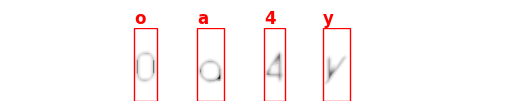

In [150]:
## plot image and bounding boxes
def plot_image(image, boxes, labels):
    """Plot image with bounding boxes."""
    fig, ax = plt.subplots()
    ax.imshow(image, cmap='gray')

    for i, box in enumerate(boxes):
        x, y, w, h = box
        rect = plt.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(x, y - 5, labels[i] if i < len(labels) else "", color='r', fontsize=12, weight='bold')

    plt.axis('off')
    plt.show()

sample = 'oa4y-0.png'
image_path = "dataset/train/0a4y-0.png"
print(image_path)
image, gray, denoised, dilated_once, dilated_twice = preprocess_image(image_path)


# Check if preprocessing was successful
if image is not None:
    # Get bounding boxes and segmented characters
    boxes, char_images = show_segmentation(dilated_twice)
    
    if boxes:
        print(f"Found {len(boxes)} bounding boxes.")
    else:
        print("No bounding boxes found.")
    # Extract labels from the filename
    base_name = list(sample.split('-')[0])
    print(f"Labels: {base_name}")

    # Plot the image with bounding boxes
    plot_image(dilated_twice, boxes, base_name)
else:
    print("Image preprocessing failed.")


In [151]:

input_dir = 'processed_dataset'  # 使用已处理的数据集

# 加载处理好的数据
data = []
labels = []

for folder in ['train', 'test']:
    folder_path = os.path.join(input_dir, folder)
    for filename in os.listdir(folder_path):
        if filename.endswith('.png'):
            image_path = os.path.join(folder_path, filename)
            label_text = filename.split('_')[0]  # 获取完整字符串
            char_index = int(filename.split('_')[-1].split('.')[0])  # 获取字符的索引
            label_char = label_text[char_index]  # 获取对应的字符

            img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                data.append(cv2.resize(img, (30, 60)))
                labels.append(label_char)

# 将数据标准化并调整维度
data = np.array(data) / 255.0  # 标准化
data = data[..., np.newaxis]  # 添加通道维度

# 将标签转换为数字编码
char_to_num = {char: i for i, char in enumerate('abcdefghijklmnopqrstuvwxyz0123456789')}
labels = np.array([char_to_num[char] for char in labels])

# 拆分训练和测试集
split_index = int(0.8 * len(data))
x_train, y_train = data[:split_index], labels[:split_index]
x_test, y_test = data[split_index:], labels[split_index:]

In [152]:
import visualkeras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from PIL import Image  # Ensure PIL is imported
from PIL import ImageFont

def create_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(60, 30, 1)),
        MaxPooling2D((2, 2)),
        Dropout(0.2),

        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.2),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(36, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [153]:
print("Shape of x_train:", x_train.shape)
print("Shape of y_train:", y_train.shape)


Shape of x_train: (39281, 60, 30, 1)
Shape of y_train: (39281,)


In [154]:
model = create_model()
model.fit(x_train, y_train, epochs=30, validation_split=0.1, shuffle=True)

Epoch 1/30
1105/1105 ━━━━━━━━━━━━━━━━━━━━ 19s 17ms/step - accuracy: 0.2465 - loss: 2.7512 - val_accuracy: 0.6312 - val_loss: 1.3445
Epoch 2/30
1105/1105 ━━━━━━━━━━━━━━━━━━━━ 18s 17ms/step - accuracy: 0.5312 - loss: 1.6201 - val_accuracy: 0.6701 - val_loss: 1.1984
Epoch 3/30
1105/1105 ━━━━━━━━━━━━━━━━━━━━ 18s 16ms/step - accuracy: 0.5838 - loss: 1.4220 - val_accuracy: 0.7022 - val_loss: 1.0556
Epoch 4/30
1105/1105 ━━━━━━━━━━━━━━━━━━━━ 18s 16ms/step - accuracy: 0.6145 - loss: 1.3185 - val_accuracy: 0.7078 - val_loss: 0.9945
Epoch 5/30
1105/1105 ━━━━━━━━━━━━━━━━━━━━ 18s 16ms/step - accuracy: 0.6377 - loss: 1.2272 - val_accuracy: 0.7300 - val_loss: 0.9649
Epoch 6/30
1105/1105 ━━━━━━━━━━━━━━━━━━━━ 19s 17ms/step - accuracy: 0.6506 - loss: 1.1654 - val_accuracy: 0.7345 - val_loss: 0.9314
Epoch 7/30
1105/1105 ━━━━━━━━━━━━━━━━━━━━ 19s 17ms/step - accuracy: 0.6609 - loss: 1.1271 - val_accuracy: 0.7406 - val_loss: 0.9004
Epoch 8/30
1105/1105 ━━━━━━━━━━━━━━━━━━━━ 18s 17ms/step - accuracy: 0.6725 -

In [155]:
def create_model1():
    model = keras.Sequential([
        layers.Input(shape=(60, 30, 1)),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.2),

        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.2),

        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.2),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.Dense(64, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.Dense(36, activation='softmax')  # 36个输出，对应26个字母和10个数字
    ])

    # 设置Adam优化器并调整学习率
    optimizer = keras.optimizers.Adam(learning_rate=keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.001,
        decay_steps=10000,
        decay_rate=0.9,
        staircase=True))
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [ ]:
model1 = create_model1()
model1.fit(x_train, y_train, epochs=20, validation_split=0.1, shuffle=True)

Epoch 1/20
1105/1105 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.2718 - loss: 2.7674

In [ ]:
def create_model2(input_shape=(60, 30, 1), num_classes=36, dropout_rate=0.5):
    inputs = layers.Input(shape=input_shape)

    # Convolutional layers
    x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(inputs)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)

    # Adding a Dropout layer after convolutional layers
    x = layers.Dropout(dropout_rate)(x)

    # Calculate the new shape
    height = x.shape[1]  # height after convolution and pooling
    width = x.shape[2]   # width after convolution and pooling
    channels = x.shape[3]  # channels after convolution
    new_shape = (height, width * channels)  # Reshape to (time_steps, features)

    # Reshape for LSTM input
    x = layers.Reshape(target_shape=new_shape)(x)

    # Recurrent layers
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)
    x = layers.Dropout(dropout_rate)(x)  # Adding dropout after the first LSTM

    x = layers.Bidirectional(layers.LSTM(128, return_sequences=False))(x)
    x = layers.Dropout(dropout_rate)(x)  # Adding dropout after the second LSTM

    # Output layer
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
model2 = create_model2()
model2.fit(x_train, y_train, epochs=20, validation_split=0.1, shuffle=True)

NameError: name 'Model' is not defined

In [ ]:
 # 测试模型
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print(f"测试集准确率: {test_acc:.2f}")


307/307 - 2s - 5ms/step - accuracy: 0.7609 - loss: 0.8821
测试集准确率: 0.76


In [ ]:
test_loss, test_acc = model1.evaluate(x_test, y_test, verbose=2)
print(f"测试集准确率: {test_acc:.2f}")

307/307 - 5s - 17ms/step - accuracy: 0.0306 - loss: 3.5835
测试集准确率: 0.03


In [ ]:
test_loss, test_acc = model2.evaluate(x_test, y_test, verbose=2)
print(f"测试集准确率: {test_acc:.2f}")

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

def plot_classification_report(y_true, y_pred, class_names):
    """Generates a classification report."""
    report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    
    plt.figure(figsize=(12, 6))
    sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap="Blues", fmt=".2f")
    plt.title("Classification Report")
    plt.show()

def plot_confusion_matrix(y_true, y_pred, class_names):
    """Generates a confusion matrix."""
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(20, 12))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()


In [ ]:
y_pred_prob = model.predict(x_test)  # Predict probabilities for each class
y_pred = np.argmax(y_pred_prob, axis=1)  # Convert probabilities to class labels
y_true = np.argmax(y_test, axis=0) 

307/307 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


In [ ]:
import pandas as pd

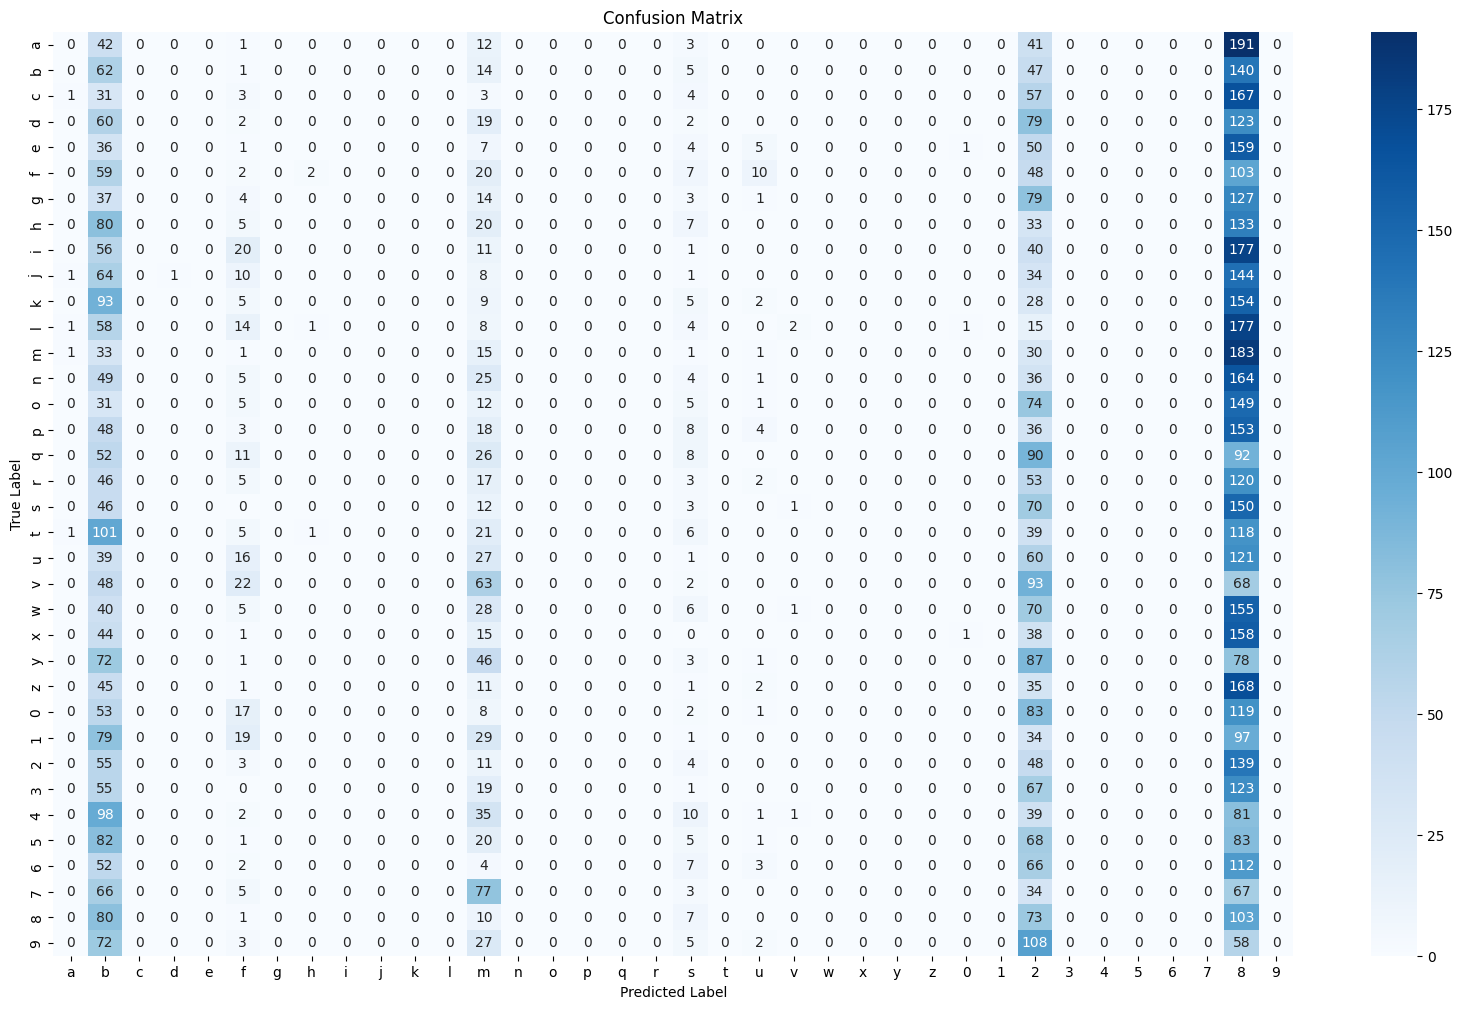

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

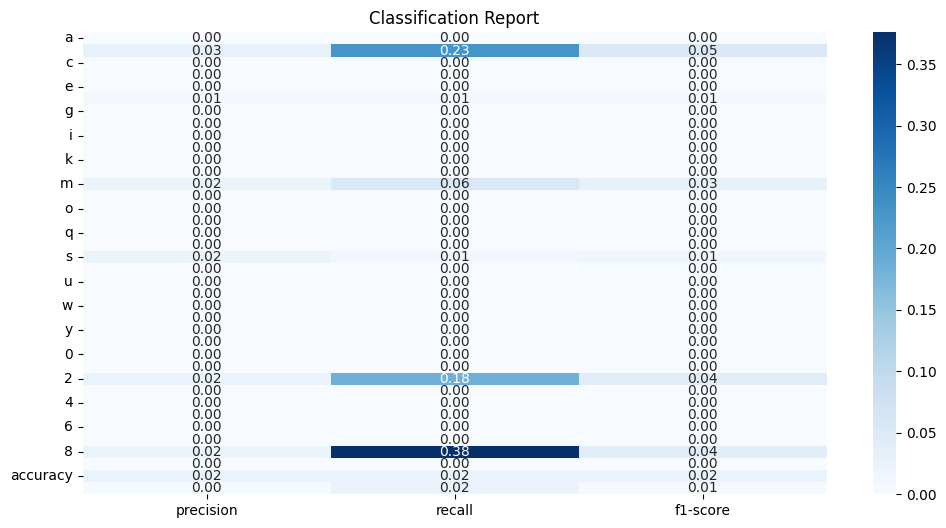

In [ ]:
class_names = list('abcdefghijklmnopqrstuvwxyz0123456789')
plot_confusion_matrix(y_test, y_pred, class_names)
plot_classification_report(y_test, y_pred, class_names)

In [ ]:
y_pred_prob = model1.predict(x_test)  # Predict probabilities for each class
y_pred = np.argmax(y_pred_prob, axis=1)  # Convert probabilities to class labels
y_true = np.argmax(y_test, axis=0)

307/307 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step


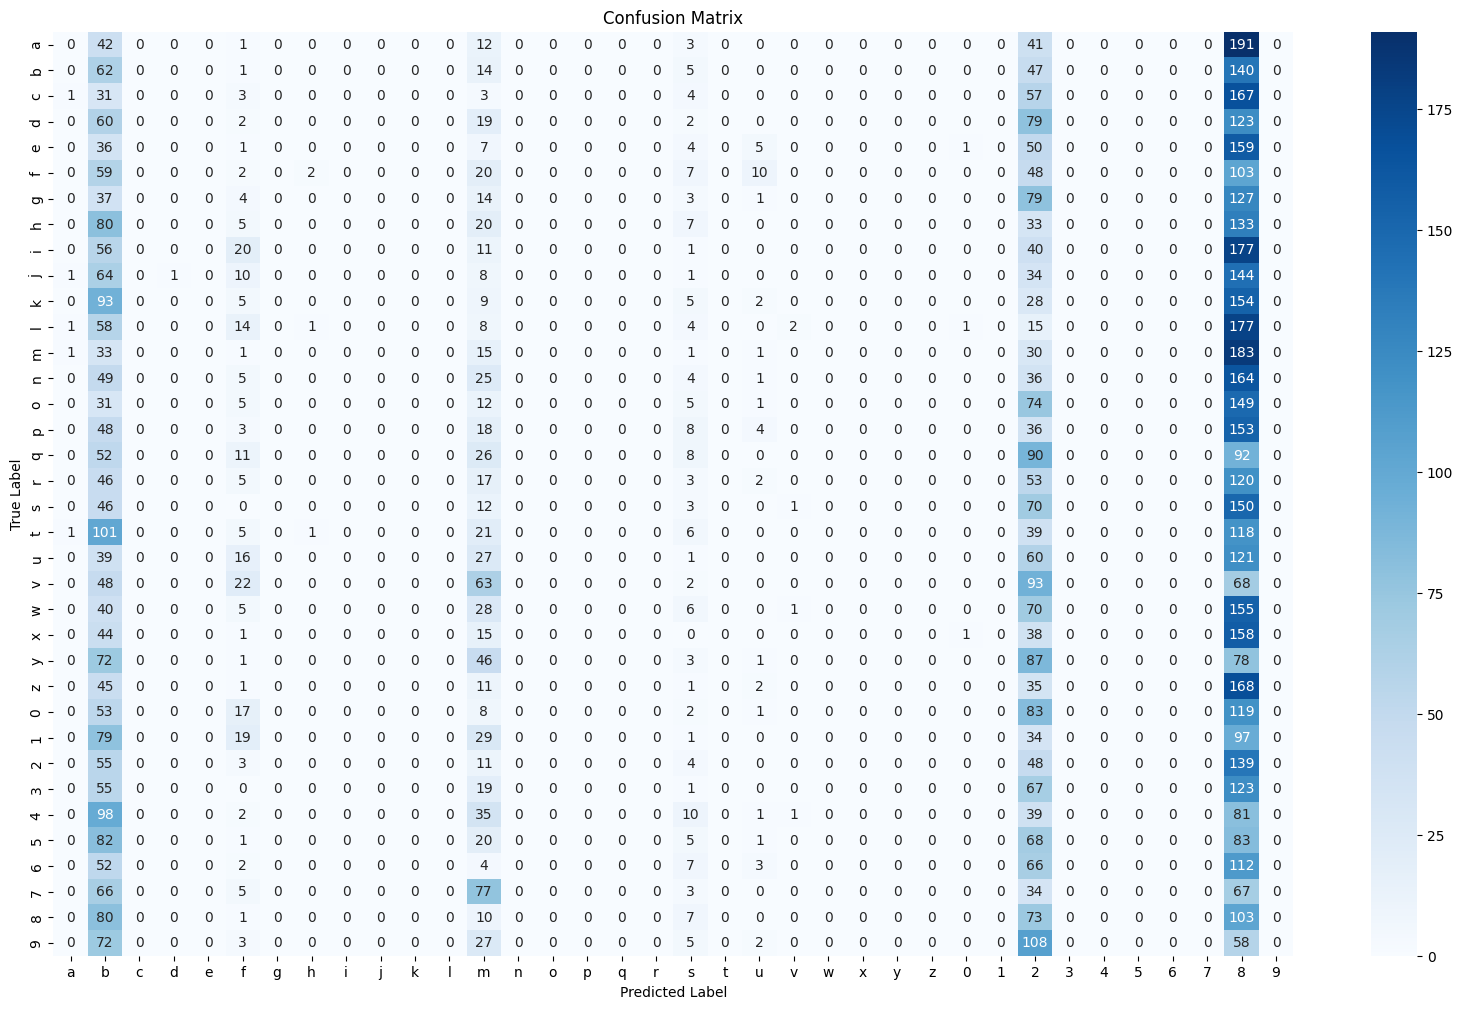

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

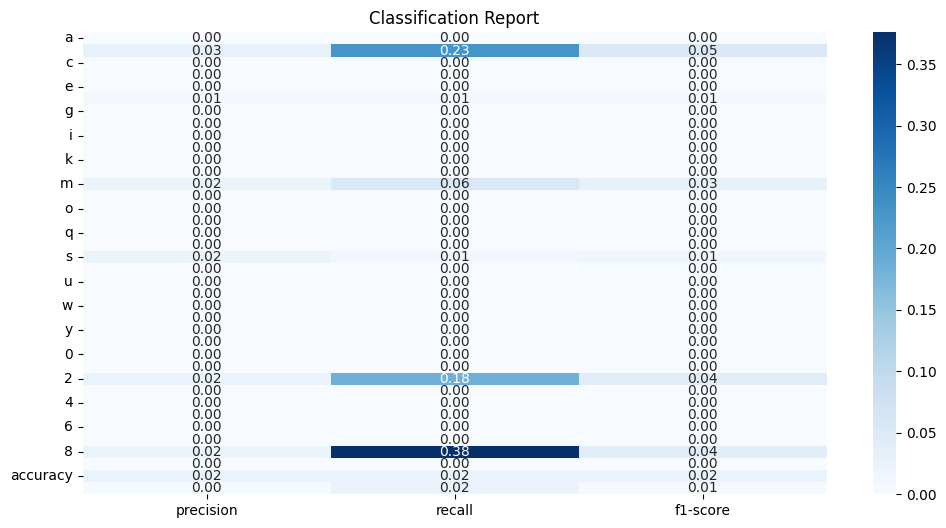

In [ ]:
class_names = list('abcdefghijklmnopqrstuvwxyz0123456789')
plot_confusion_matrix(y_test, y_pred, class_names)
plot_classification_report(y_test, y_pred, class_names)

In [ ]:
y_pred_prob = model2.predict(x_test)  # Predict probabilities for each class
y_pred = np.argmax(y_pred_prob, axis=1)  # Convert probabilities to class labels
y_true = np.argmax(y_test, axis=0)

In [ ]:
class_names = list('abcdefghijklmnopqrstuvwxyz0123456789')
plot_confusion_matrix(y_test, y_pred, class_names)
plot_classification_report(y_test, y_pred, class_names)

In [ ]:
def load_test_data(test_dir):
    """Loads test images and groups them by CAPTCHA."""
    captcha_dict = {}
    
    for filename in os.listdir(test_dir):
        if filename.endswith('.png'):
            # Extract the CAPTCHA identifier and character index
            parts = filename.split('_')
            captcha_id = parts[0][:-2]  # e.g., '0a7sh2wp'
            char_index = int(parts[2].split('.')[0])  # e.g., 'char_0' -> 0

            # Preprocess the image
            image_path = os.path.join(test_dir, filename)
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)


            if captcha_id not in captcha_dict:
                captcha_dict[captcha_id] = []
            captcha_dict[captcha_id].append((char_index, image))
    
    # Sort characters within each CAPTCHA by their index
    for captcha_id in captcha_dict:
        captcha_dict[captcha_id] = [img for _, img in sorted(captcha_dict[captcha_id])]
    
    return captcha_dict

def predict_captcha(model, captcha_images):
    """Predicts characters for a given set of images representing a single CAPTCHA."""
    captcha_images = np.array(captcha_images)
    predictions = model.predict(captcha_images)
    
    char_to_num = {i: char for i, char in enumerate('abcdefghijklmnopqrstuvwxyz0123456789')}
    predicted_chars = [char_to_num[np.argmax(pred)] for pred in predictions]
    
    return ''.join(predicted_chars)

def evaluate_model(model, test_dir):
    """Evaluates the model on the test set by checking full CAPTCHA correctness and character-level accuracy."""
    captcha_dict = load_test_data(test_dir)
    correct_count = 0
    total_count = len(captcha_dict)
    total_character_accuracy = 0.0
    total_characters = 0

    for captcha_id, captcha_images in captcha_dict.items():
        # Predict the CAPTCHA
        predicted_text = predict_captcha(model, captcha_images)
        print(f"Predicted: {predicted_text}, Ground Truth: {captcha_id}")

        # Check if the predicted text matches the ground truth (full CAPTCHA correctness)
        if predicted_text == captcha_id:
            correct_count += 1

        # Calculate character-level correctness
        captcha_length = max(len(captcha_id), len(predicted_text))
        char_correct = sum(1 for gt_char, pred_char in zip(captcha_id, predicted_text) if gt_char == pred_char)
        
        # Account for the case where predicted_text is shorter than captcha_id
        char_correct += abs(len(captcha_id) - len(predicted_text))

        # Update character accuracy statistics
        total_character_accuracy += char_correct / captcha_length
        total_characters += 1

    # Calculate full CAPTCHA accuracy
    captcha_accuracy = correct_count / total_count if total_count > 0 else 0
    avg_character_accuracy = total_character_accuracy / total_characters if total_characters > 0 else 0

    print(f"Full CAPTCHA accuracy: {captcha_accuracy:.2f} ({correct_count}/{total_count})")
    print(f"Average character-level accuracy: {avg_character_accuracy:.2f}")

    return captcha_accuracy, avg_character_accuracy


In [ ]:
test_dir = os.path.join(input_dir, 'test')
evaluate_model(model, test_dir)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Predicted: 07wk, Ground Truth: o7wk
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Predicted: h0m1a, Ground Truth: h0n14
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Predicted: sjbflf, Ground Truth: 9kdflf
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Predicted: r5wz7, Ground Truth: r5wz7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Predicted: 3w4exb4, Ground Truth: 3w4cxb4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Predicted: bpc5hioe, Ground Truth: bpc5hioe
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Predicted: d8d6g47, Ground Truth: 48qgg4t
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Predicted: pkalsl, Ground Truth: ph2tst
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Predicted: 9y4j9qb5, Ground Truth: 9y4j9qb5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Predicted: sm10n3dv, Ground Truth: sml0n3dv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Predicted: nqdrscn5, Ground Truth: nqdrscn5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Predicted: y0zs1, Ground Truth: 4ozs1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Predicted: 3vslm

(0.30132850241545894, 0.7223983494363917)

In [ ]:
test_dir = os.path.join(input_dir, 'test')
evaluate_model(model1, test_dir)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Predicted: d080, Ground Truth: o7wk
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
Predicted: 00080, Ground Truth: h0n14
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predicted: 000d08, Ground Truth: 9kdflf
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predicted: 0800d, Ground Truth: r5wz7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Predicted: 0000000, Ground Truth: 3w4cxb4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Predicted: 00000000, Ground Truth: bpc5hioe
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Predicted: 000000u, Ground Truth: 48qgg4t
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted: 800000, Ground Truth: ph2tst
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted: 00d0008d, Ground Truth: 9y4j9qb5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Predicted: 000d000u, Ground Truth: sml0n3dv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted: 00000000, Ground Truth: nqdrscn5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predicted: u0000, Ground Truth: 4ozs1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Predicted: 000d0

(0.0, 0.03035929951690821)

In [ ]:
test_dir = os.path.join(input_dir, 'test')
evaluate_model(model2, test_dir)

NameError: name 'model2' is not defined